# Import Packages

In [1]:
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.layers import Dropout, Flatten, Dense, Input

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load training data 

In [2]:
train_df = pd.read_csv('train.csv')
print(train_df.shape)

(28709, 2)


In [3]:
train_df.head(5)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


### 

# Preprocessing

In [4]:
# create a 4D array of pixel values

train_df['pixels'] = [np.fromstring(x, dtype=int, sep=' ').reshape(-1,48,48,1) for x in train_df['pixels']]

In [5]:
pixels = np.concatenate(train_df['pixels'])
labels = train_df.emotion.values

print(pixels.shape)
print(labels.shape)

(28709, 48, 48, 1)
(28709,)


# Label Distribution

In [6]:
train_dist = (train_df.emotion.value_counts() / len(train_df)).to_frame().sort_index(ascending=True).T

train_dist

,0,1,2,3,4,5,6
emotion,0.139155,0.015187,0.142708,0.251315,0.16824,0.110453,0.172942


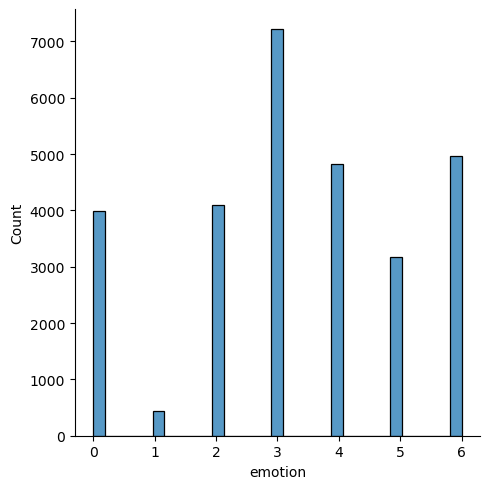

In [7]:
import seaborn as sns


sns.displot(train_dist, x=train_df.emotion)

# View samples of images

In [8]:
emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

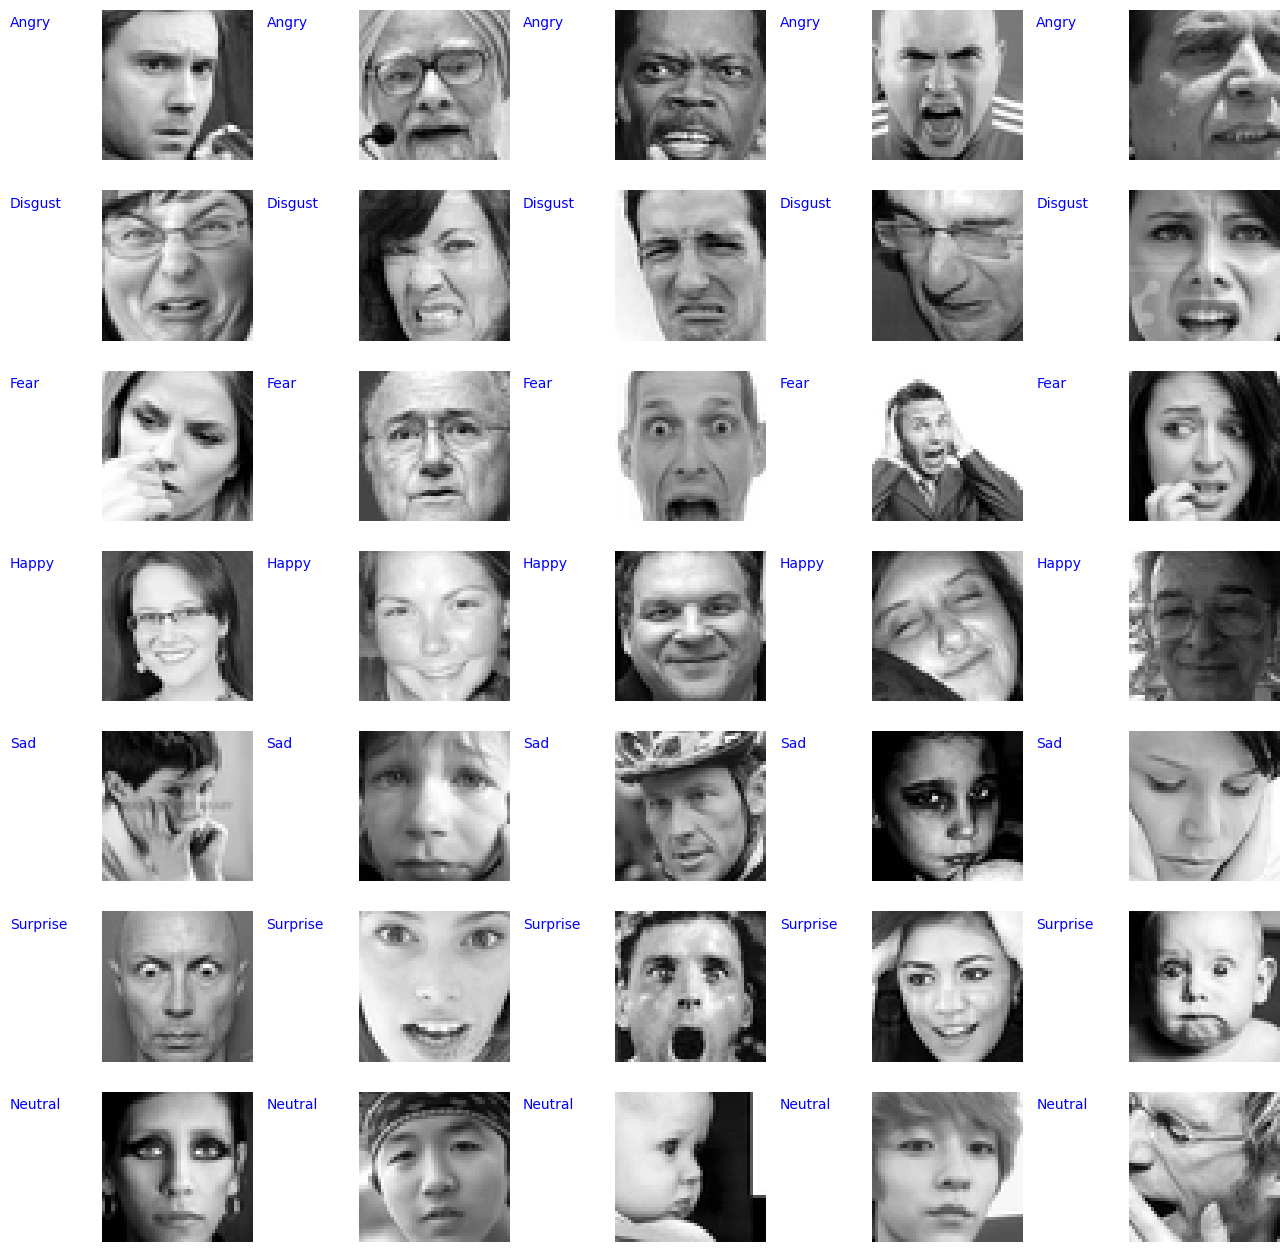

In [9]:
plt.close()
plt.rcParams["figure.figsize"] = [16,16]

row = 0
for emotion in np.unique(labels):

    all_emotion_images = train_df[train_df['emotion'] == emotion]
    for i in range(5):
        
        img = all_emotion_images.iloc[i,].pixels.reshape(48,48)
        lab = emotions[emotion]

        plt.subplot(7,5,row+i+1)
        plt.imshow(img, cmap='binary_r')
        plt.text(-30, 5, s = str(lab), fontsize=10, color='b')
        plt.axis('off')
    row += 5

plt.show()


# Data splitting for training and validation  

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(
    pixels, labels, test_size=0.2, stratify=labels, random_state=1
)


print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print()
print('X_valid Shape:', X_valid.shape)
print('y_valid Shape:', y_valid.shape)

X_train Shape: (22967, 48, 48, 1)
y_train Shape: (22967,)

X_valid Shape: (5742, 48, 48, 1)
y_valid Shape: (5742,)


In [11]:
# normalizing 
Xs_train = X_train / 255
Xs_valid = X_valid / 255

# Starting with a base model 

In [12]:
np.random.seed(1)
tf.random.set_seed(1)

base_model = tf.keras.applications.VGG16(
    input_shape = (48, 48, 1), 
    include_top = False, 
    weights = None #'imagenet'
)

base_model.trainable = False

tf.keras.utils.plot_model(base_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

# Creating a new model 

In [14]:
np.random.seed(1)
tf.random.set_seed(1)

cnn = Sequential([
    Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape=(48,48,1)),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    BatchNormalization(),
    
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    BatchNormalization(),


    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.65),
    BatchNormalization(),
    
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    BatchNormalization(),

    Flatten(),
    
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.65),
    Dense(64, activation='relu'),
    Dropout(0.25),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        1

# Training the model 

In [15]:
opt = tf.keras.optimizers.Adam(0.001)
cnn.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Training No-1 

In [16]:
%time 

h1 = cnn.fit(
    Xs_train, y_train, 
    batch_size = 32,
    epochs = 100,
    verbose = 1,
    validation_data = (Xs_valid, y_valid)
)

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/100
718/718 [==============================] - 182s 247ms/step - loss: 2.0127 - accuracy: 0.2015 - val_loss: 1.8260 - val_accuracy: 0.2198
Epoch 2/100
718/718 [==============================] - 175s 243ms/step - loss: 1.8255 - accuracy: 0.2417 - val_loss: 1.9695 - val_accuracy: 0.1886
Epoch 3/100
718/718 [==============================] - 165s 230ms/step - loss: 1.7909 - accuracy: 0.2570 - val_loss: 1.8684 - val_accuracy: 0.2292
Epoch 4/100
718/718 [==============================] - 166s 231ms/step - loss: 1.7438 - accuracy: 0.2880 - val_loss: 1.7474 - val_accuracy: 0.2811
Epoch 5/100
718/718 [==============================] - 165s 230ms/step - loss: 1.6679 - accuracy: 0.3326 - val_loss: 1.7815 - val_accuracy: 0.2898
Epoch 6/100
718/718 [==============================] - 171s 238ms/step - loss: 1.5203 - accuracy: 0.3970 - val_loss: 1.4312 - val_accuracy: 0.4293
Epoch 7/100
718/718 [==============================] - 174s 242ms/step - loss: 

In [17]:
history = h1.history
print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


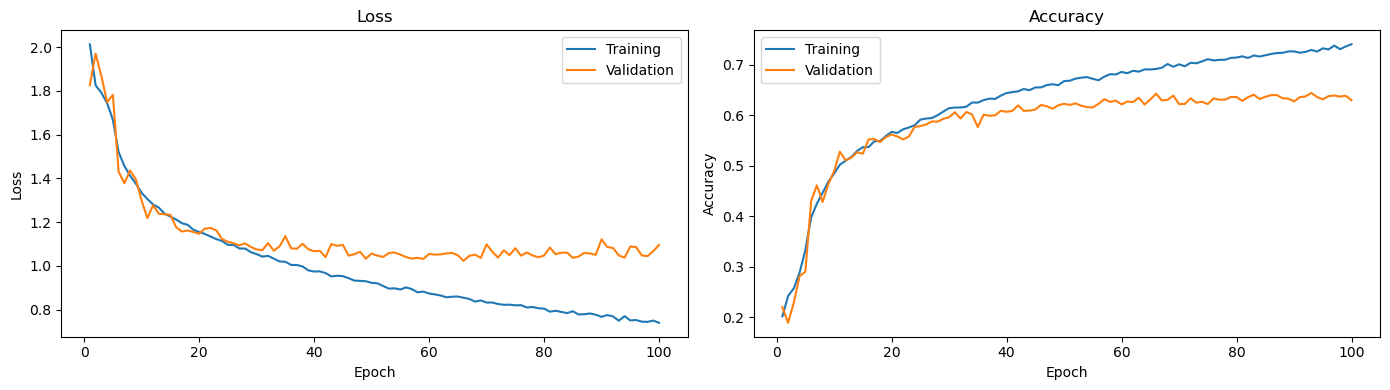

In [18]:
epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# Training No-2

In [19]:
tf.keras.backend.set_value(cnn.optimizer.learning_rate, 0.0001)

In [20]:
%time 

h2 = cnn.fit(
    Xs_train, y_train, 
    batch_size=32,
    epochs = 40,
    verbose = 1,
    validation_data = (Xs_valid, y_valid)
)

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/40
718/718 [==============================] - 178s 247ms/step - loss: 0.7035 - accuracy: 0.7537 - val_loss: 1.0494 - val_accuracy: 0.6425
Epoch 2/40
718/718 [==============================] - 178s 248ms/step - loss: 0.6927 - accuracy: 0.7531 - val_loss: 1.0605 - val_accuracy: 0.6435
Epoch 3/40
718/718 [==============================] - 174s 242ms/step - loss: 0.6855 - accuracy: 0.7554 - val_loss: 1.0549 - val_accuracy: 0.6463
Epoch 4/40
718/718 [==============================] - 171s 239ms/step - loss: 0.6763 - accuracy: 0.7632 - val_loss: 1.0541 - val_accuracy: 0.6463
Epoch 5/40
718/718 [==============================] - 208s 290ms/step - loss: 0.6752 - accuracy: 0.7632 - val_loss: 1.0522 - val_accuracy: 0.6447
Epoch 6/40
718/718 [==============================] - 212s 295ms/step - loss: 0.6654 - accuracy: 0.7656 - val_loss: 1.0618 - val_accuracy: 0.6479
Epoch 7/40
718/718 [==============================] - 212s 296ms/step - loss: 0.6652 

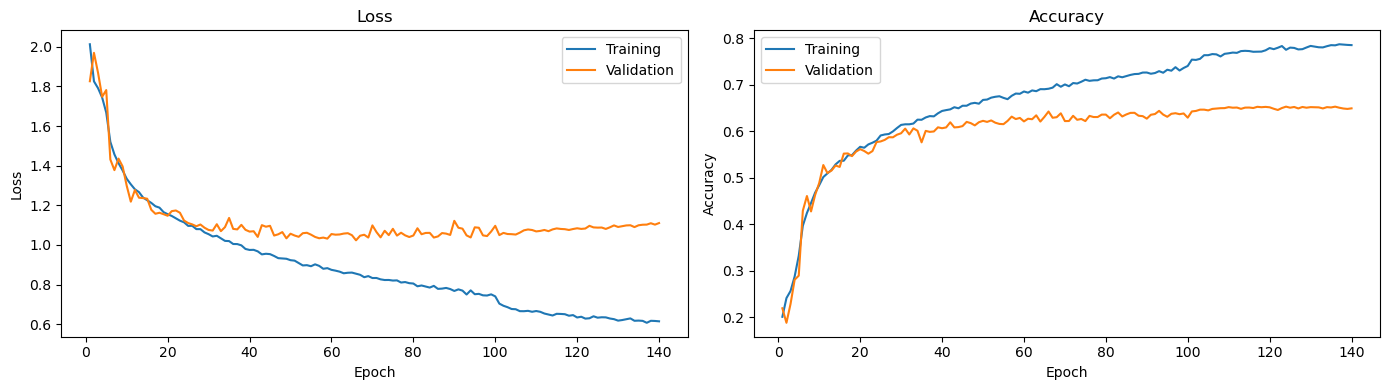

In [21]:
for k in history.keys():
    history[k] += h2.history[k]

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Training No-3

In [22]:
tf.keras.backend.set_value(cnn.optimizer.learning_rate, 0.00001)

In [23]:
%time 

h3 = cnn.fit(
    Xs_train, y_train, 
    batch_size=32,
    epochs = 200,
    verbose = 1,
    validation_data = (Xs_valid, y_valid)
)

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/200
718/718 [==============================] - 181s 252ms/step - loss: 0.6153 - accuracy: 0.7834 - val_loss: 1.1043 - val_accuracy: 0.6517
Epoch 2/200
718/718 [==============================] - 181s 252ms/step - loss: 0.6063 - accuracy: 0.7872 - val_loss: 1.1008 - val_accuracy: 0.6531
Epoch 3/200
718/718 [==============================] - 178s 248ms/step - loss: 0.5988 - accuracy: 0.7910 - val_loss: 1.0999 - val_accuracy: 0.6527
Epoch 4/200
718/718 [==============================] - 179s 250ms/step - loss: 0.6055 - accuracy: 0.7877 - val_loss: 1.1042 - val_accuracy: 0.6527
Epoch 5/200
718/718 [==============================] - 181s 251ms/step - loss: 0.6033 - accuracy: 0.7900 - val_loss: 1.1011 - val_accuracy: 0.6529
Epoch 6/200
718/718 [==============================] - 179s 249ms/step - loss: 0.6058 - accuracy: 0.7841 - val_loss: 1.1019 - val_accuracy: 0.6534
Epoch 7/200
718/718 [==============================] - 177s 247ms/step - loss: 

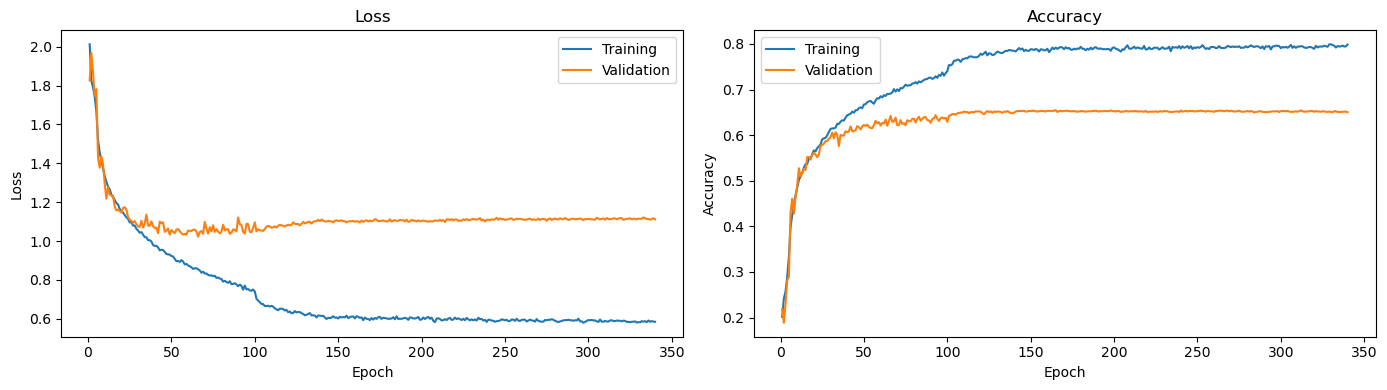

In [24]:
for k in history.keys():
    history[k] += h3.history[k]

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Save Model

In [25]:
cnn.save('facial_recognition_model.h5')
pickle.dump(history, open(f'facial_recognition.pkl', 'wb'))

D:\Anaconda\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


References

Sample notebook
https://www.kaggle.com/code/jefffossi/week3-fossi

VGG Model

https://keras.io/api/applications/vgg/#vgg16-function

# 